# Forecasting With Classical and Machine Learning Methods Using sktime

![](../images/problem_statement.png)

![](../images/presentation_agenda.png)

![](../images/time_series_definition.png)

In [3]:
import warnings
warnings.filterwarnings("ignore")
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()
y

Period
1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
1991-06    168.5
1991-07    231.8
1991-08    224.5
1991-09    192.8
1991-10    122.9
1991-11    336.5
1991-12    185.9
1992-01    194.3
1992-02    149.5
1992-03    210.1
1992-04    273.3
1992-05    191.4
1992-06    287.0
1992-07    226.0
1992-08    303.6
1992-09    289.9
1992-10    421.6
1992-11    264.5
1992-12    342.3
1993-01    339.7
1993-02    440.4
1993-03    315.9
1993-04    439.3
1993-05    401.3
1993-06    437.4
1993-07    575.5
1993-08    407.6
1993-09    682.0
1993-10    475.3
1993-11    581.3
1993-12    646.9
Freq: M, Name: Number of shampoo sales, dtype: float64

What makes time series problems unique?  

Autocorrelation.

Auto-correlation violates the assumption that your data is independent and identically distributed.

Most ml models are built on the assumption of i.i.d. data

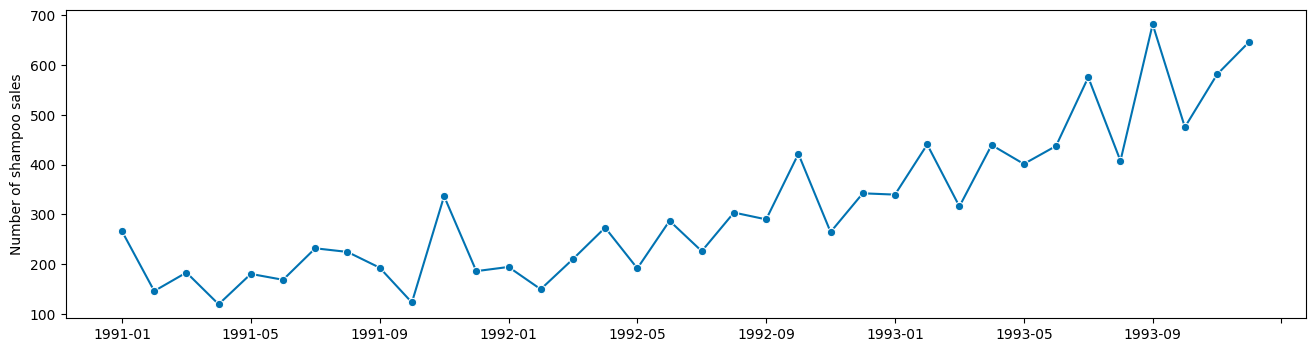

In [4]:
# airlines data
from sktime.utils.plotting import plot_series

fig, ax = plot_series(y)

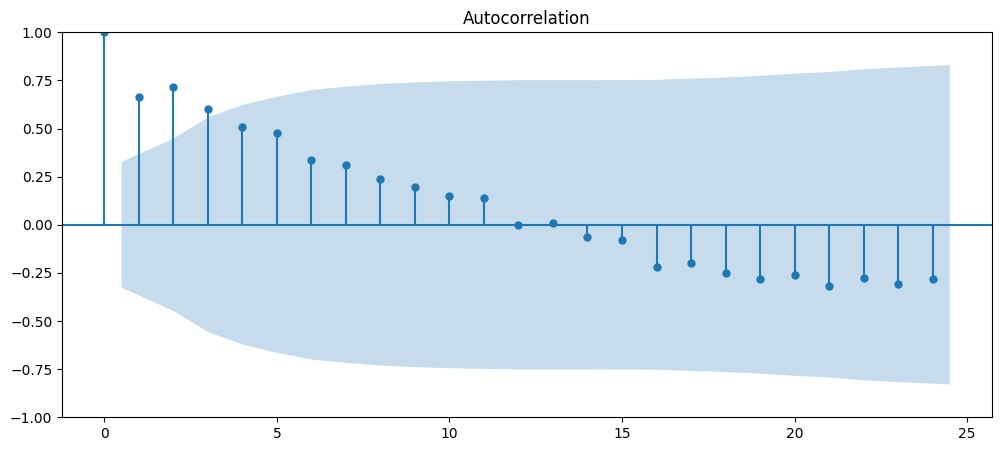

In [6]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(y, lags=24, ax = ax)
plt.show()

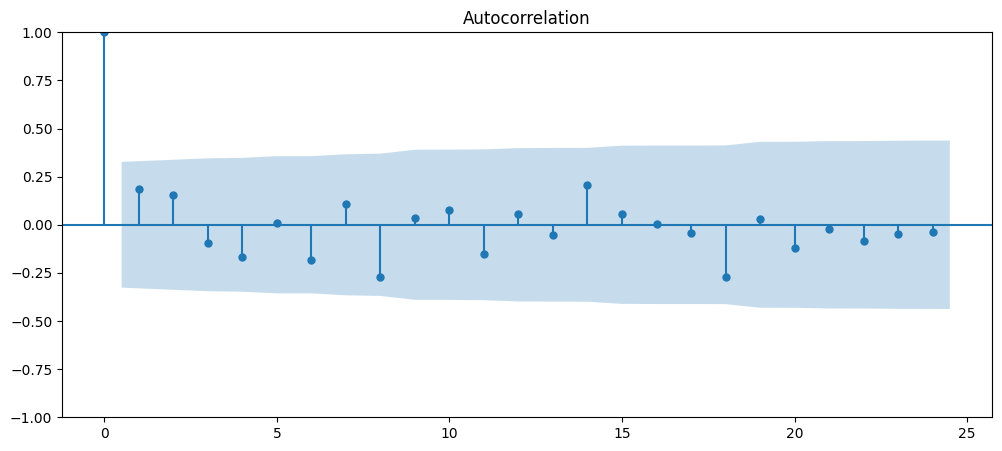

In [8]:
# for comparison, here's what this plot would look like if you shuffle this data
import numpy as np

shuffled_data = np.random.permutation(y)

fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(shuffled_data, lags=24, ax = ax)
plt.show()

Statistical learning models are typically built on the assumption that your data is i.i.d.  

Time series models are built to accommodate the statistical structure of temporally dependent data by accounting for trend and auto-correlation.  

Common examples of time series models include:  Exponential Smoothing, ARIMA, Theta, etc.  

Using time series models for forecasting problems has been standard up until the current day.  

ML models with large parameters frequently underperform classical time series methods.  

Case in point:  the Monash Forecasting Repository.  https://forecastingdata.org/

Collection of 30 datasets to use as benchmarks.

Time series models often outperform more contemporary techniques.

![Monash Forecasting Results](../images/monash_respository.png)

However, there are compelling reasons to want to use ML for forecasting problems.  

 - Ability to recognize non-linear patterns
 - Ability to incorporate large amounts of non-time based exogenous data
 - Ability to capture global patterns among many time series
 - Recent successes using ML in forecasting competitions

![](../images/m5_3.png)

![](../images/m5_1.png)

Using ML for forecasting problems presents some issues.

Data has to undergo pre-processing to make it usable for forecasting.  

![sktime](../images/unified_framework.png)

There are **many** choices for time series tools in the python ecosystem

**practically none** for making them work together harmoniously

Sktime provides an easy, flexible interface for working through time series problems

How to prepare time series data for ML?

ML models don't have an innate ability to "see" previous samples in the data.  

![tabularization](../images/tabularization.png)

The following code will recreate the above diagram and fit it to a histogram based gradient boosting model.

In [9]:
from sktime.forecasting.naive import NaiveForecaster

naive_forecaster = NaiveForecaster(strategy = 'last')

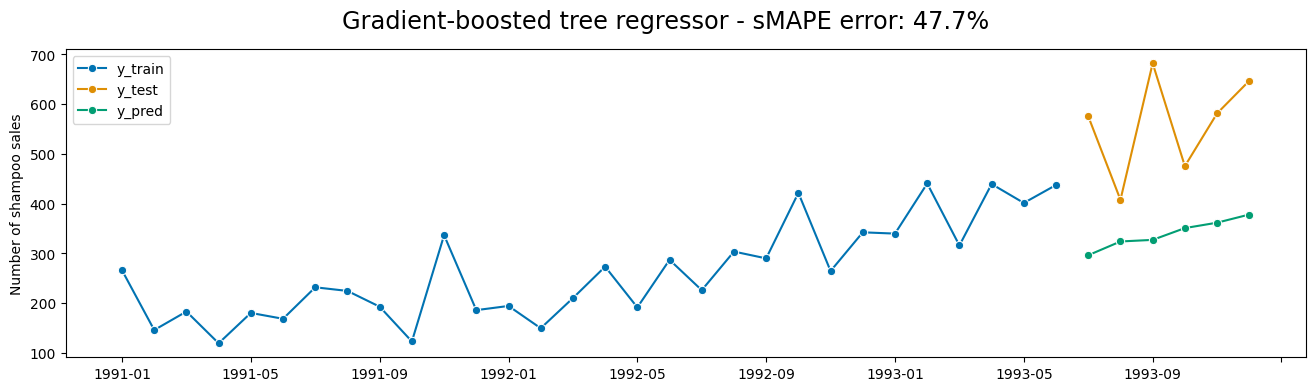

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

y_train, y_test = temporal_train_test_split(y=y, test_size=6)

fh = [1, 2, 3, 4, 5, 6]

# Can be swapped with XBGoost, LightGBM, CatBoost, etc.
regressor = HistGradientBoostingRegressor()

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

y_pred = forecaster.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

the `regressor` algorithm can be any estimator that has a `fit` and `predict` method.  

The `make_reduction` function transforms previous values into exogenuous variables.

However, a quick eyeball test reveals these predictions to be unsatisfactory.  

It also does not outperform an AutoARIMA model out of the box.

In [11]:
from sktime.forecasting.arima import AutoARIMA

arima_forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
y_pred_arima = arima_forecaster.fit_predict(y=y_train, fh=fh)

print(f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}")
print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred_arima):.1%}")

Gradient-boosted tree regressor - sMAPE error: 47.7%
AutoARIMA - sMAPE error: 40.1%


Why is the GBM under-performing?:

- Gradient boosting trees cannot "extrapolate"
- only forecast well within their observed range

Solution: make (more) stationary by differencing

easy to do in `sktime`: transformers (= transformation estimators)

(note: wider concept than deep learn transformers, includes simple trafos too)

Let's see how to use the `Differencer` transformer:

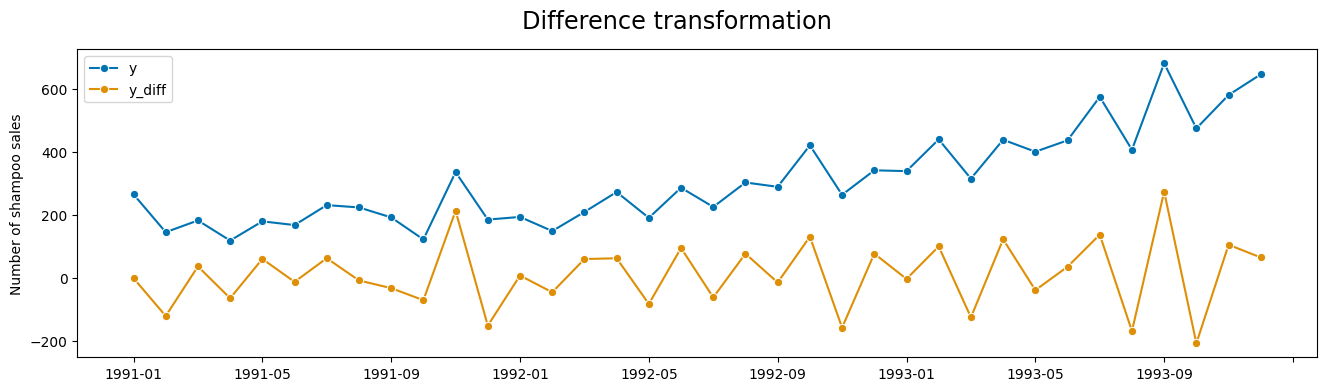

In [13]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
fig, ax = plot_series(
    y, y_transform, labels=["y", "y_diff"], title="Difference transformation"
)

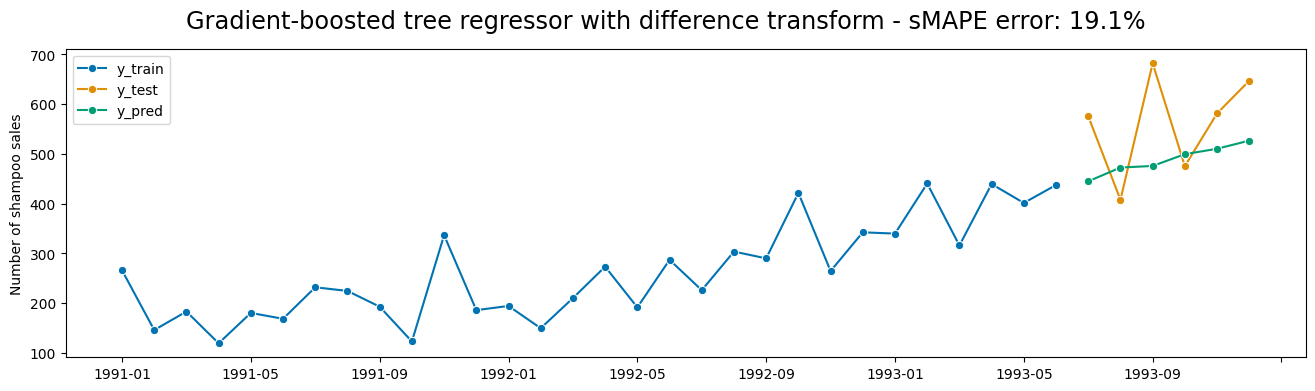

In [15]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)
forecaster_with_differencer = Differencer(lags=1) * forecaster

# to do:  use transformed target forecaster for this step
y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

We would like to take this example extend it to account for more complicated scenarios:  

 - Forecasting many time series simultaneously, many of which may be interrelated.
 - Producing features beyond using lag values

### Panel Forecasting With ML and sktime

The examples so far have focused on a single time series.

However, most real world problems often involve multiple time series, many of which exist in a hierarchy.

![hierarchical time series](../images/hierarchy.png)

In [16]:
# example hierarchical time series
from pydata_utils import load_product_hierarchy

y = load_product_hierarchy()

y

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

A key component of hierarchical time series is that many of the individual time series are related to one another. 

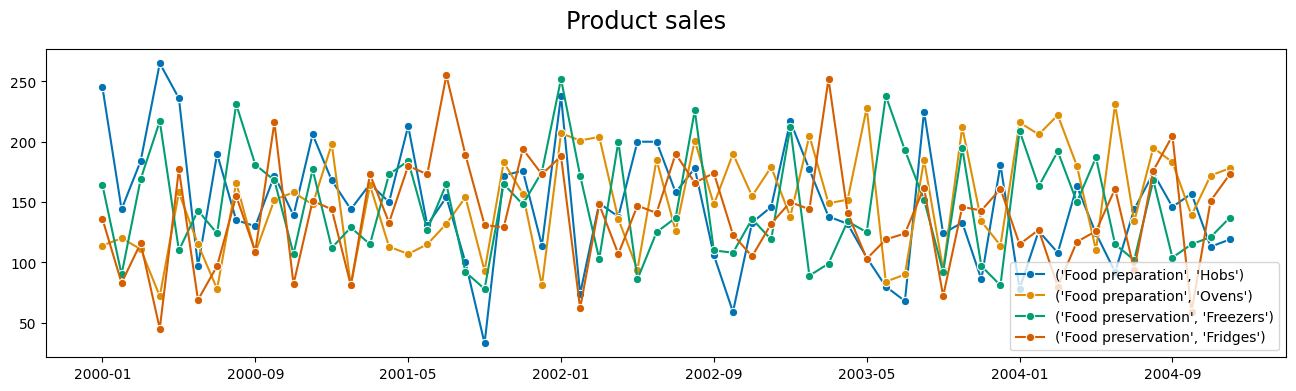

In [17]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(*(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales")

Traditionally, each individual time series would be modeled separately.  

This approach potentially misses the shared properties of the different time series, making their modeling inefficient.  

For ML models, a better approach is often to fit all of the time series jointly.

Simultaneously fitting many time series is known as global forecasting.

It's been the approach that's been successfully used with ML models in competitions.

Using global approaches to model many time series is straight forward in sktime.

In [18]:
# create the train and test sets
y_train, y_test = temporal_train_test_split(y, test_size=4)

# to do:  add in differencing w/ transformed targetforecaster
regressor         = HistGradientBoostingRegressor()
forecaster_local  = make_reduction(regressor, strategy="direct", window_length=12, pooling="local")
forecaster_global = make_reduction(regressor, strategy="direct", window_length=12, pooling="global")
forecaster_arima  = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)

hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")

y_pred_local = forecaster_local.fit_predict(y_train, fh=[1, 2, 3, 4])
y_pred_global = forecaster_global.fit_predict(y_train, fh=[1, 2, 3, 4])
y_pred_arima = forecaster_arima.fit_predict(y_train, fh = [1, 2, 3, 4])

errors_local = hier_smape(y_test, y_pred_local)
errors_global = hier_smape(y_test, y_pred_global)
errors_arima = hier_smape(y_test, y_pred_arima)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")
print(f"Average sMAPE with AutoARIMA: {errors_arima.mean().iloc[0]:.1%}")

Average sMAPE with local pooling: 27.5%
Average sMAPE with global pooling: 22.9%
Average sMAPE with AutoARIMA: 21.7%


### Feature Engineering

Machine learning models often benefit from feature engineering beyond lags

Examples:
 - Summary statistics for a given time series
 - Window statistics for a given time series

Producing these features can easily be added to sktime pipelines.

In [19]:
from sktime.transformations.series.summarize import WindowSummarizer

# arguments for the window transformer
kwargs = {
    "lag_feature": {
        "lag": [1, 2, 3],
        "mean": [[1, 3]],
        "std": [[1, 10]],
        "kurt": [[1, 10]]},
    "truncate": 'bfill'
}

summarizer = WindowSummarizer(**kwargs, n_jobs = 1)
window_data = summarizer.fit_transform(y_train)
window_data

Sales_lag_1  Sales_lag_2  \
Product line      Product group Date                                
Food preparation  Hobs          2000-01        245.0        245.0   
                                2000-02        245.0        245.0   
                                2000-03        144.0        245.0   
                                2000-04        184.0        144.0   
                                2000-05        265.0        184.0   
...                                              ...          ...   
Food preservation Fridges       2004-04         80.0        127.0   
                                2004-05        117.0         80.0   
                                2004-06        126.0        117.0   
                                2004-07        161.0        126.0   
                                2004-08         94.0        161.0   

                                         Sales_lag_3  Sales_mean_1_3  \
Product line      Product group Date                                   
Food preparation  Hobs          2000-01        245.0      211.333333   
                                2000-02        245.0      211.333333   
                                2000-03        245.0      211.333333   
                                2000-04        245.0      191.000000   
                                2000-05        144.0      197.666667   
...                                              ...             ...   
Food preservation Fridges       2004-04        115.0      107.333333   
                                2004-05        127.0      108.000000   
                                2004-06         80.0      107.666667   
                                2004-07        117.0      134.666667   
                                2004-08        126.0      127.000000   

                                         Sales_std_1_10  Sales_kurt_1_10  
Product line      Product group Date                                      
Food preparation  Hobs          2000-01       58.815059        -1.560127  
                                2000-02       58.815059        -1.560127  
                                2000-03       58.815059        -1.560127  
                                2000-04       58.815059        -1.560127  
                                2000-05       58.815059        -1.560127  
...                                                 ...              ...  
Food preservation Fridges       2004-04       30.559414        -0.384103  
                                2004-05       30.608822        -0.433587  
                                2004-06       30.610274        -0.409658  
                                2004-07       30.476949        -0.403151  
                                2004-08       26.816247        -0.555609  

[224 rows x 6 columns]

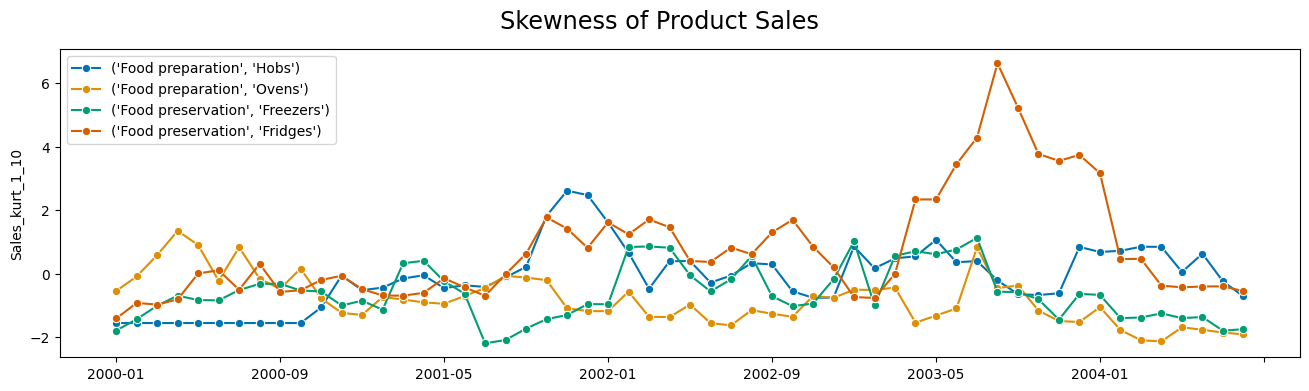

In [20]:
# window statistics can capture local patterns in a time series
# not easily observed by lag values alone
fig, ax = plot_series(*(window_data.loc[idx, 'Sales_kurt_1_10'] for idx in product_index), 
                      labels=product_index, title="Skewness of Product Sales")

In [21]:
from sktime.transformations.series.summarize import WindowSummarizer

# arguments for the window transformer
kwargs = {
    "lag_feature": {
        "lag": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "mean": [[1, 3]],
        "std": [[1, 10]],
        "kurt": [[1, 10]]},
    "truncate": 'bfill'
}

forecaster_window = make_reduction(
    regressor,
    transformers=[WindowSummarizer(**kwargs, n_jobs=1)],
    window_length=None,
    strategy="direct",
    pooling="global",
)

y_pred_global_window = forecaster_window.fit_predict(y_train, fh=[1, 2, 3, 4])
errors_global_window = hier_smape(y_test, y_pred_global_window)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")
print(f"Average sMAPE with AutoARIMA: {errors_arima.mean().iloc[0]:.1%}")
print(f"Average sMAPE with window transformations: {errors_global_window.mean().iloc[0]:.1%}")

Average sMAPE with local pooling: 27.5%
Average sMAPE with global pooling: 22.9%
Average sMAPE with AutoARIMA: 21.7%
Average sMAPE with window transformations: 18.9%


As we can see in the above example, we've now beat the AutoARIMA baseline.  

Global forecasting also has faster fitting times than local forecasting.

In [22]:
%timeit forecaster_window.fit(y_train, fh=[1, 2, 3, 4])
%timeit forecaster_arima.fit(y_train, fh=[1, 2, 3, 4])

452 ms ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.9 s ± 72.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Overview

What did we cover today?  

 - Time series models and machine learning models can both successfuly be used for forecasting
 - Time series models are easier to use "out of the box" on a single time series
 - ML models can make more sense for modeling time series simultaneously
 - You should expect to do feature engineering when time series modeling with ML
 - `sktime` provides a helpful interface for unifying the workflows for the tasks described today